# Text Alignment Pipeline

In [1]:
import pymorphy2
import re
import torch
import seaborn as sns
import numpy as np
import razdel

from scipy import spatial
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelWithLMHead

Error: Jupyter cannot be started. Error attempting to locate jupyter: Data Science libraries jupyter and notebook are not installed in interpreter Python 3.8.2 64-bit.

In [3]:
import os

pattern_ru_orig = re.compile(r'[a-zA-Z\(\)\[\]\/\<\>•\'\n]+')
double_spaces = re.compile(r'[\s]+')
double_commas = re.compile(r'[,]+')
double_dash = re.compile(r'[-—]+')
pattern_zh = re.compile(r'[」「“”„‟\x1a⓪①②③④⑤⑥⑦⑧⑨⑩⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽*a-zA-Zа-яА-Я\(\)\[\]\s\n\/\-\:•＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》【】〔〕〖〗〘〙〜〟〰〾〿–—‘’‛‧﹏〉]+')
pat_comma = re.compile(r'[\.]+')
first_numbers = re.compile(r'^[0-9,\.]+')
last_punct = re.compile(r'[,\.]+$')
multiple_spaces = re.compile(r'\s+')
pattern_ru = re.compile(r'[a-zA-Z\.\(\)\[\]\/\-\:!?\<\>;•\"\'«»——,]+')
pattern_ru_letters_only = re.compile(r'[^а-яА-Я\s]+')

def split_zh(paragraph):
    for sent in re.findall(u'[^!?。！？\.\!\?]+[!?。！？\.\!\?]?', paragraph, flags=re.U):
        yield sent
            
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModelWithLMHead.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

def get_sent_vec(text):
    tokenized_text = tokenizer.encode(text, add_special_tokens=True)
    #indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor(tokenized_text).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        return model(tokens_tensor)[0]

#лемматизация
morph = pymorphy2.MorphAnalyzer()

def get_file_vectors(path_ru):
    ru_vectors = []
    with open(path_ru, mode="r", encoding="utf-8") as input_ru:
        for line_ru in input_ru.readlines():
            line_ru = re.sub(pattern_ru, '', line_ru).strip()
            line_ru = re.sub(last_punct, '', line_ru).strip()
            line_ru = re.sub(first_numbers, '', line_ru).strip()
            line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
            line_ru = line_ru.lower()

            line_ru = ' '.join(list(map(lambda x: morph.parse(x)[0].normal_form, line_ru.split())))
            #print(line_ru)
            ru_vectors.append(get_sent_vec(line_ru))
    return ru_vectors

def get_line_vectors(lines):
    ru_vectors = []
    for line_ru in lines:
        line_ru = re.sub(pattern_ru, '', line_ru).strip()
        line_ru = re.sub(last_punct, '', line_ru).strip()
        line_ru = re.sub(first_numbers, '', line_ru).strip()
        line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
        line_ru = line_ru.lower()

        line_ru = ' '.join(list(map(lambda x: morph.parse(x)[0].normal_form, line_ru.split())))
        #print(line_ru)
        ru_vectors.append(get_sent_vec(line_ru))
    return ru_vectors

In [4]:
def get_pairs(ru_lines, zh_lines, ru_proxy_lines, sim_matrix, threshold):
    ru = []
    zh = []
    ru_proxy = []
    sims = []
    for i in range(sim_matrix.shape[0]):
        for j in range(sim_matrix.shape[1]):
            if sim_matrix[i,j] >= threshold:
                ru.append(ru_lines[j])
                zh.append(zh_lines[i])
                ru_proxy.append(ru_proxy_lines[i])
                sims.append(sim_matrix[i,j])
                
    return ru,zh,ru_proxy,sims

def get_sim_matrix(ru_vec, ru_vec2, window=10):
    sim_matrix=np.zeros((len(ru_vec), len(ru_vec2)))
    k = len(ru_vec)/len(ru_vec2)
    for i in range(len(ru_vec)):
        for j in range(len(ru_vec2)):
            if (j*k > i-window) & (j*k < i+window):
                sim = 1 - spatial.distance.cosine(ru_vec[i][0,-1,:], ru_vec2[j][0,-1,:])
                sim_matrix[i,j] = sim

    return sim_matrix  

def align_texts(file_ru, file_zh, threshold, batch_size=50, window=10, n_gram=1, n_gram_sent_max_words=20, l_diff=0.8, debug=False, vectors_ru1=None, vectors_ru2=None):
    
    splitted_ru = os.path.join("D:\ml\c\splitted", os.path.basename(file_ru))
    splitted_zh = os.path.join("D:\ml\c\splitted", os.path.basename(file_zh))
    proxy_ru = os.path.join("D:\ml\c\proxy", os.path.basename(file_ru))    
    ngramed_splitted_zh = os.path.join("D:\ml\c\gramed", os.path.basename(file_zh))
    ngramed_proxy_ru = os.path.join("D:\ml\c\gramed", os.path.basename(file_ru))    
    output_ru = os.path.join("D:\ml\c\done", os.path.basename(file_ru))
    output_zh = os.path.join("D:\ml\c\done", os.path.basename(file_zh))
    
    print("Splitting ru.")
    with open(file_ru, mode='r', encoding='utf-8') as input_ru, open(splitted_ru, mode='w', encoding='utf-8') as out_ru:
        ru = ' '.join(input_ru.readlines())
        ru = re.sub(pattern_ru_orig, '', ru)
        ru = re.sub(double_spaces, ' ', ru)
        ru = re.sub(double_commas, ',', ru)
        ru = re.sub(double_dash, '—', ru)

        sent_ru = list(x.text for x in razdel.sentenize(ru))

        count = 1
        for x in sent_ru:
            if count < len(sent_ru)-1:
                out_ru.write(x.strip() + "\n")
            else:
                out_ru.write(x.strip())
            count += 1
            
    print("Russian text lines:", len(sent_ru), "\n")
    
    print("Splitting zh.")
    with open(file_zh, mode='r', encoding='utf-8') as input_zh, open(splitted_zh, mode='w', encoding='utf-8') as out_zh:
        zh = ''.join(input_zh.readlines())    
        zh = re.sub(pat_comma, '。', zh)

        sent_zh = list(re.sub(pattern_zh,'',x.strip()) for x in split_zh(zh))

        count = 1
        for x in sent_zh:
            if count < len(sent_zh)-1:
                out_zh.write(x.strip() + "\n")
            else:
                out_zh.write(x.strip())
            count += 1

    print("Chinese text lines:", len(sent_zh), "\n")    
    
    #check if proxy file exists
    if not(os.path.isfile(proxy_ru)):
        raise Exception("Proxy file not found:", proxy_ru)
    
    print("Proxy file is found:")
    print(proxy_ru + "\n")
    
    print("Creating ngrammed by sentence text files...")
    #ngramming
#     max_sent_words = 20 #don't process very long sentences.
    count_ngramed = 0
    with open(splitted_zh, mode="r", encoding="utf-8") as input_zh, \
         open(proxy_ru, mode="r", encoding="utf-8") as input_proxy, \
         open(ngramed_splitted_zh, mode='w', encoding='utf-8') as ngram_zh, \
         open(ngramed_proxy_ru, mode='w', encoding='utf-8') as ngram_ru:
        lines_zh = input_zh.readlines()
        lines_ru_proxy = input_proxy.readlines()
        file_len = len(lines_ru_proxy)
        
        for i in range(file_len):
            #process sentence
            #always write original sentence
            ngram_ru.write(lines_ru_proxy[i].strip() + "\n")
            ngram_zh.write(lines_zh[i].strip() + "\n")
            count_ngramed += 1
            #add ngamed sentences
            for k in range(1, n_gram):
                #write if every sentence is longer than max_sent_words
                to_write = True
                line_ru = ""
                line_zh = ""
                for j in range(k+1):
                    if (len(re.sub(pattern_ru_letters_only,'',lines_ru_proxy[min(i+j, file_len-1)]).split())>n_gram_sent_max_words):
                        to_write = False
                    line_ru += lines_ru_proxy[min(i+j, file_len-1)].strip()
                    line_ru += " "
                    
                    line_zh += lines_zh[min(i+j, file_len-1)].strip()
                    
                    #ngram_ru.write(lines_ru_proxy[min(i+j, file_len-1)].strip() + " ")
                    #ngram_zh.write(lines_zh[min(i+j, file_len-1)].strip() + " ")
                if to_write:
                    ngram_ru.write(line_ru + "\n")
                    ngram_zh.write(line_zh + "\n")
                    count_ngramed += 1
                    #ngram_zh.write("\n")
    
    
    
    print("Ngrammed Chinese text lines:", count_ngramed, "\n")   
#     raise Exception("debug")
    
    #batching    
    with open(splitted_ru, mode="r", encoding="utf-8") as input_ru, \
         open(ngramed_splitted_zh, mode="r", encoding="utf-8") as input_zh, \
         open(ngramed_proxy_ru, mode="r", encoding="utf-8") as input_proxy:
        lines_ru = input_ru.readlines()
        lines_zh = input_zh.readlines()
        lines_ru_proxy = input_proxy.readlines()    
    
    batch_number = 0
    total_pairs = 0
    with open(output_ru, mode='w', encoding='utf-8') as out_ru, open(output_zh, mode='w', encoding='utf-8') as out_zh:
        for lines_ru_batch, lines_ru_proxy_batch, lines_zh_batch in get_batch(lines_ru, lines_ru_proxy, lines_zh, batch_size):
            batch_number += 1

            #print(lines_ru_batch)
            
            print("--------------------------------------")
            print("batch:", batch_number, "[", (batch_number-1) * batch_size, "-", batch_number * batch_size, "]", "Calculating vectors...")
            vectors_ru1 = get_line_vectors(lines_ru_proxy_batch)
            vectors_ru2 = get_line_vectors(lines_ru_batch)
            
#             if vectors_ru1 is None:
#                 vectors_ru1 = get_line_vectors(lines_ru_proxy_batch)
#             if vectors_ru2 is None:
#                 vectors_ru2 = get_line_vectors(lines_ru_batch)

            print("Calculating similarity matrix...")
            sim_matrix = get_sim_matrix(vectors_ru1, vectors_ru2, window)  

            plt.figure(figsize=(12,10))
            sns.heatmap(sim_matrix,cmap="Greens", vmin=threshold)
            plt.show()
            
            count = 0
            for i in range(sim_matrix.shape[0]):
                for j in range(sim_matrix.shape[1]):
                    if sim_matrix[i,j] >= threshold:
                        count += 1
            total_pairs += count
            print("\nPairs found:", count, "\n")
            print("\nTotal pairs found:", total_pairs, "\n")
            print("--------------------------------------")
            
            res_ru, res_zh, res_ru_proxy, sims = get_pairs(lines_ru_batch, lines_zh_batch, lines_ru_proxy_batch, sim_matrix, threshold)

            for x,y,z,s in zip(res_ru, res_zh, res_ru_proxy, sims):
                #filter if res and proxy length is differ to much
                x_len = len(re.sub(pattern_ru_letters_only,'',x).split())
                z_len = len(re.sub(pattern_ru_letters_only,'',z).split())
                xz_diff = min(x_len,z_len)/max(x_len,z_len)
                if debug:
                    print("----------------------------------------------------------------------------")
                    print("similarity:", s)
                    print("length diff:", xz_diff)
                    if xz_diff < l_diff:
                        print("[filtered]")
                    print("--------------------------------------")
                
                if (debug) | (xz_diff >= l_diff):
                    out_ru.write(x)
                    out_zh.write(y)                    
                    print(x)
                    print(z)
                    print(y)

    print("Done. Total pairs found:", total_pairs)
    
    return vectors_ru1, vectors_ru2

def get_batch(iter1, iter2, iter3, n):
    l1 = len(iter1)
    l3 = len(iter3)
    k = int(round(n * l3/l1))    
    kdx = 0 - k
    for ndx in range(0, l1, n):
        kdx += k
        yield iter1[ndx:min(ndx + n, l1)], iter2[kdx:min(kdx + k, l3)], iter3[kdx:min(kdx + k, l3)]

Splitting ru.
Russian text lines: 170 

Splitting zh.
Chinese text lines: 192 

Proxy file is found:
D:\ml\c\proxy\_chekhov_6_ru.txt

Creating ngrammed by sentence text files...
Ngrammed Chinese text lines: 213 

--------------------------------------
batch: 1 [ 0 - 100 ] Calculating vectors...
Calculating similarity matrix...


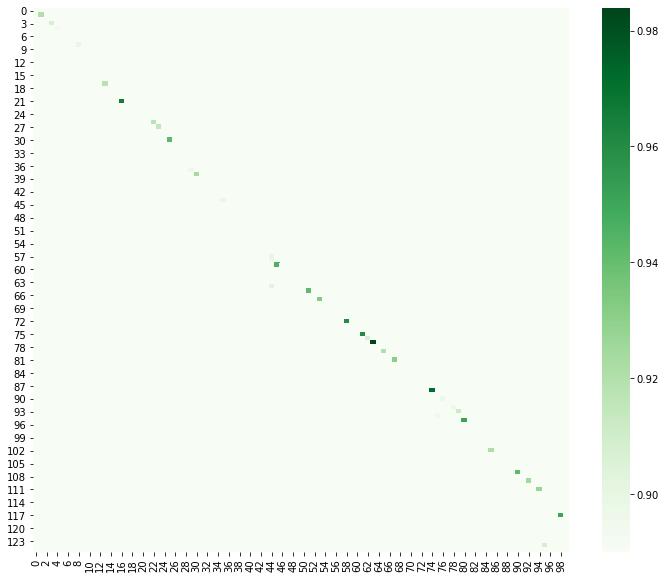


Pairs found: 39 


Total pairs found: 39 

--------------------------------------
Крыша на нем ржавая, труба наполовину обвалилась, ступеньки у крыльца сгнили и поросли травой, а от штукатурки остались одни только следы.

Крыша этого отсека была ржавой, труба была наполовину искривлена ​​и наполовину наклонена, ступени перед дверью обветшали, покрыты сорняками, и на стене остались только пятнистые остатки штукатурки.

这幢厢房的屋顶生了锈，烟囱半歪半斜，门前台阶已经朽坏，长满杂草，墙面的灰泥只剩下些斑驳的残迹。

Эти гвозди, обращенные остриями кверху, и забор, и самый флигель имеют тот особый унылый, окаянный вид, какой у нас бывает только у больничных и тюремных построек.

Стены и комнаты с гвоздями, направленными вверх, имеют особую мрачную и греховную картину только в наших больницах и тюрьмах.

那些尖头朝上的钉子那围墙那厢房本身，都有一种特别的阴郁的罪孽深重的景象，只有我们的医院和监狱的房屋才会这样。

Если вы не боитесь ожечься о крапиву, то пойдемте по узкой тропинке, ведущей к флигелю, и посмотрим, что делается внутри.

Если вы не боитесь укуса крапивы, тогда вы идете по кишеч

Calculating similarity matrix...


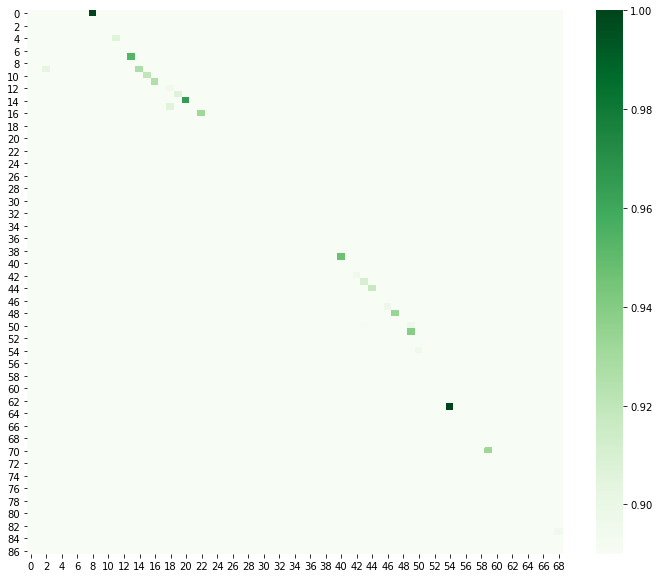


Pairs found: 25 


Total pairs found: 64 

--------------------------------------
Почему они молчат?

Почему они молчат?

为什么他们沉默呢？

В полдень обыкновенно исправник проезжал на паре по улице; это он ехал из своего подгородного имения в полицейское правление, но Ивану Дмитричу казалось каждый раз, что он едет слишком быстро и с каким—то особенным выражением: очевидно, опешит объявить, что в городе проявился очень важный преступник.

В полдень генеральный инспектор округа прошел через улицу в конном экипаже, когда он отвез машину из усадьбы в пригороде в полицейский участок, но Иван Деметрич чувствовал, что его машина каждый раз ходит слишком быстро. И особый взгляд на его лице.

中午，县瞽察局长照例坐着一辆双马马车走过大街，这是他从近郊的庄园坐车到警察局去，可是伊万德米特里奇每回都觉得他的车子走得太快，而且他的脸上有一种特别的神情。

Он не спал все ночи напролет, ожидая ареста, но громко храпел и вздыхал, как сонный, чтобы хозяйке казалось, что он спит; ведь если не спит, то значит, его мучают угрызения совести — какая улика!

Он беспокоился о том, чтобы быть ар

In [10]:
#0.87 - 104
file_ru = r"D:\ml\c\raw\chekhov_futlar_ru.txt"
file_zh = r"D:\ml\c\raw\chekhov_futlar_zh.txt"

#
# file_ru = r"D:\ml\c\raw\stal_ru.txt"
# file_zh = r"D:\ml\c\raw\stal_zh.txt"

# #0.84 - 22
# file_ru = r"D:\ml\c\raw\lu_xun_ben_ye_ru.txt"
# file_zh = r"D:\ml\c\raw\lu_xun_ben_ye_zh.txt"

# file_ru = r"D:\ml\c\raw\idiot_ru.txt"
# file_zh = r"D:\ml\c\raw\idiot_zh.txt"

# file_ru = r"D:\ml\c\raw\master_ru.txt"
# file_zh = r"D:\ml\c\raw\master_zh.txt"

file_ru = r"D:\ml\c\raw\_chekhov_6_ru.txt"
file_zh = r"D:\ml\c\raw\_chekhov_6_zh.txt"

v1, v2 = align_texts(file_ru, file_zh, threshold=0.89, batch_size=100, window=12, n_gram=2, \
                     n_gram_sent_max_words=12, l_diff=0.6, debug=False)

In [64]:
#v1, v2 = align_texts(file_ru, file_zh, 0.85, v1, v2)